In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.linear_model import LinearRegression
from lib.cartpoleenv import CartPoleEnv
from lib.cartpolesystem import CartPoleSystem, Cart, Pole, StepperMotor
from lib.numerical import rk4_step

In [4]:
dt = 0.005
g = 9.81
r = 0.04456
m = 0.2167
x_max = 1.15/2

# 45.4 g outer
# l1 = 0.200
# a1 = 0.108709
# m1 = 0.13725
# d1 = 0.003
# J1 = 0.00092347
# pole1 = Pole(m1, l1, a1, d1, J1)

# # 55 g outer
l2 = 0.200
a2 = 0.116161
m2 = 0.14945
d2 = 0.001
J2 = 0.001017455
pole1 = Pole(m2, l2, a2, d2, J2)

# 0 g outer
# l2 = 0.200
# a2 = 0.067341
# m2 = 0.09445
# d2 = 0.0001
# J2 = 0.00040300
# pole2 = Pole(m2, l2, a2, d2, J2)

# # 55 g outer + 72.5 g middle
# l2 = 0.200
# a2 = 0.100214
# m2 = 0.22195
# d2 = d
# J2 = 0.001133810
# pole2 = Pole(m2, l2, a2, d2, J2)

print("Calculating equations (1-5 min)...")
cart = Cart(m, 0.01, (-x_max, x_max), 0.1)
motor = StepperMotor(r, (-2.7, 2.7), 0.1, (-2, 2), 0.1)
poles = [
    pole1,
]
path = "./cartpolesystems"

system = CartPoleSystem(cart, motor, poles, g, False)

if system.check_equations(path):
    system.import_equations(path)
else:
    system.set_equations()
    system.export_equations(path)

Calculating equations (1-5 min)...


In [12]:
df = pd.read_csv('data/2024-05-02_1.csv')
print("Entries before filter: ", len(df))
df = df.dropna()
print("Entries after filter: ", len(df))
df

Entries before filter:  3737
Entries after filter:  3736


,s,d_s,theta_1,d_theta_1,u,time,T,desired_s,error_s,desired_d_s,error_d_s,desired_theta_1,error_theta_1,desired_d_theta_1,error_d_theta_1,desired_u
0,0.245655,0.00,-0.581914,0.000000,0.000000,0.000000,-0.019938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00,0.000000,0.000000,0.000000,4.186368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00,3.123185,-3.944071,0.000000,4.453548,-0.002026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00,3.127787,0.000000,0.000000,4.454996,-0.000599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00,3.127787,0.000000,0.000000,4.458831,-0.000599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3731,0.978880,3.08,-1.938952,-6.816527,-59.308881,22.983452,-0.886170,0.000074,-0.987766,-0.006206,-3.086206,-0.000430,1.986076,0.035984,8.684774,0.204285
3732,0.987840,3.08,-1.986505,-8.648790,-65.796394,22.988118,-0.957927,0.000047,-0.997313,-0.005180,-3.085180,-0.000274,2.036852,0.029933,8.936242,0.222157
3733,0.997360,3.08,-2.037126,-8.906309,-67.671243,22.992783,-0.972323,0.000026,-1.007134,-0.004043,-3.084043,-0.000150,2.093733,0.023288,10.255074,0.240029
3734,1.007160,3.08,-2.093884,-10.231786,-72.856145,22.997602,-1.020574,0.000010,-1.016950,-0.002797,-3.082797,-0.000061,2.093823,0.016070,10.247856,0.257901


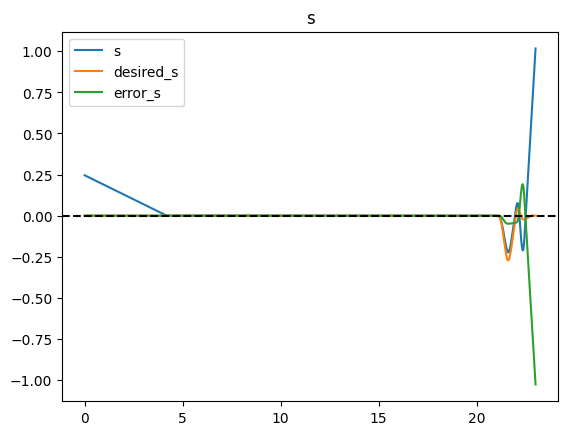

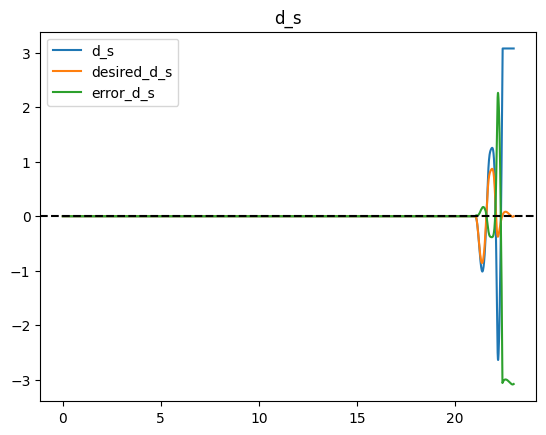

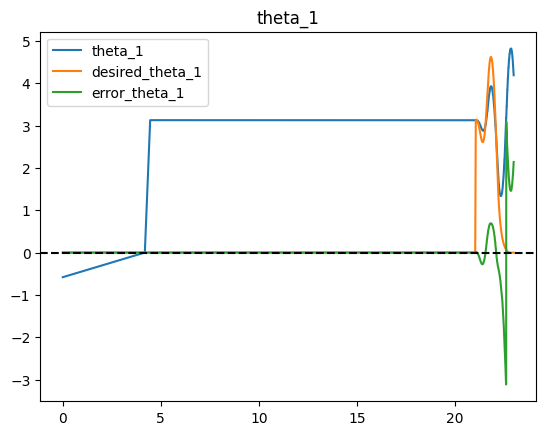

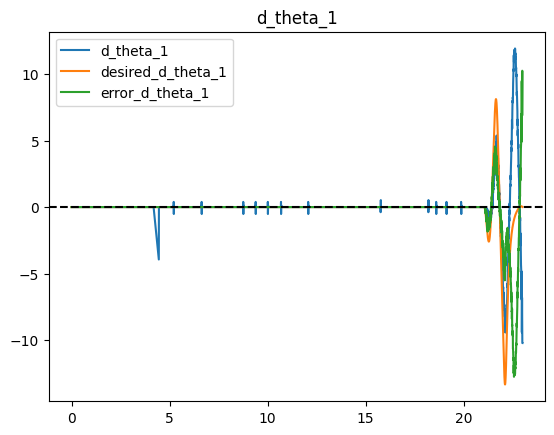

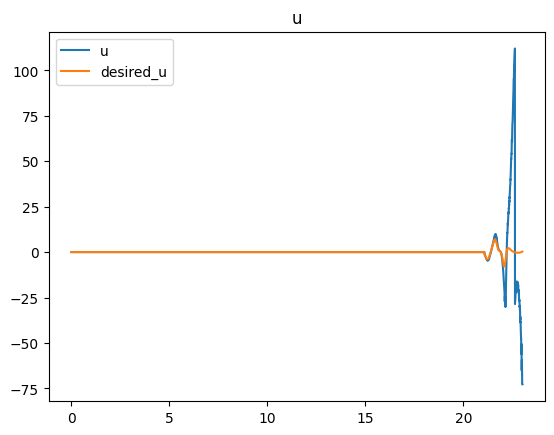

In [13]:
df = df[(df['time'] >= 20) & (df['time'] <= 1071)]

time = df['time']
columns = ["s", "d_s", "theta_1", "d_theta_1", "theta_2", "d_theta_2"][:2+2*system.num_poles]
desired_columns = [f"desired_{column_name}" for column_name in columns]

for column_name in columns:
    mod_pi = column_name.startswith("theta")
    desired_column_name = f"desired_{column_name}"
    error_column_name = f"error_{column_name}"
    column = df[column_name].to_numpy()
    desired_column = df[desired_column_name].to_numpy()
    error_column = df[error_column_name].to_numpy()
    if mod_pi:
        column = np.unwrap(column)
        desired_column = np.unwrap(desired_column)

    plt.plot(time, column, label=column_name)
    plt.plot(time, desired_column, label=desired_column_name)
    plt.plot(time, error_column, label=error_column_name)
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.title(column_name)
    plt.show()

plt.title("u")
plt.plot(time, df['u'], label='u')
plt.plot(time, df['desired_u'], label='desired_u')
plt.legend()

In [398]:
states = np.array(df[columns])
desired_states = np.array(df[desired_columns])

last_update = perf_counter()
env = CartPoleEnv(system, dt, rk4_step)
for state, desired_state in zip(states, desired_states):
    env.render(state, desired_state)
    while perf_counter() - last_update < dt*10:
        pass
    last_update = perf_counter()
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'

In [ ]:
import sympy as sp
import sympy.physics.mechanics as me

In [ ]:
_s = me.dynamicsymbols("s")
_d_s = sp.diff(_s)
_dd_s = sp.diff(_d_s)
_thetas = [me.dynamicsymbols(f"theta{i+1}") for i in range(system.num_poles)]      #type: ignore
_d_thetas = [sp.diff(theta) for theta in _thetas]
_dd_thetas = [sp.diff(d_theta) for d_theta in _d_thetas]
_tau = sp.symbols("tau")
_pole_ds = [sp.symbols(f"d{i+1}") for i in range(system.num_poles)]      #type: ignore

pole_pc1s = []
pole_pc2s = []
for i, (theta, a) in enumerate(zip(_thetas, system.pole_as)):
    prev_1 = 0
    prev_2 = 0
    for prev_l, prev_theta in list(zip(system.pole_ls, _thetas))[:i]:
        prev_1 += -prev_l*sp.sin(-prev_theta)       #type: ignore
        prev_2 += prev_l*sp.cos(-prev_theta)        #type: ignore
    pole_pc1s.append(_s-a*sp.sin(-theta)+prev_1)     #type: ignore
    pole_pc2s.append(a*sp.cos(-theta)+prev_2)       #type: ignore

T = 1/2*system.m_c*_d_s**2         #type: ignore
for m, pc1, pc2, J, d_theta in zip(system.pole_ms, pole_pc1s, pole_pc2s, system.pole_Js, _d_thetas):
    d_pc1 = sp.diff(pc1)
    d_pc2 = sp.diff(pc2)
    T += 1/2*m*(d_pc1**2 + d_pc2**2) + 1/2*J*d_theta**2     #type: ignore
    
V = 0   
for m, pc2 in zip(system.pole_ms, pole_pc2s):
    V += system.g*m*pc2

R = 0
prev_w = 0
for d, _d_theta in zip(_pole_ds, _d_thetas):
    R += 1/2*d*(_d_theta-prev_w)**2     #type: ignore
    prev_w = _d_theta

eqs = []
L = T-V
lh = sp.diff(sp.diff(L, _d_s)) - sp.diff(L, _s) + sp.diff(R, _d_s)     #type: ignore
rh = _tau
eqs = [lh-rh]
for theta, d_theta in zip(_thetas, _d_thetas):
    L = T-V
    lh = sp.diff(sp.diff(L, d_theta)) - sp.diff(L, theta) + sp.diff(R, d_theta)     #type: ignore
    rh = 0
    eqs.append(lh-rh)

sp_vars = _pole_ds + [_s, _d_s] + [item for pair in zip(_thetas, _d_thetas) for item in pair] + [_dd_s] + _dd_thetas
sols = sp.solve(eqs, _pole_ds)
sp_sols = [sp.simplify(sols[d]) for d in _pole_ds]
X_sols = [sol.as_numer_denom()[1] for sol in sp_sols]
Y_sols = [sol.as_numer_denom()[0] for sol in sp_sols]

In [ ]:
Y_sols[0]

0.0029200019*sin(theta1(t) - theta2(t))*Derivative(theta1(t), t)**2 - 0.0029200019*sin(theta1(t) - theta2(t))*Derivative(theta2(t), t)**2 + 0.4268356648245*sin(theta1(t)) + 0.143226093195*sin(theta2(t)) - 0.0029200019*cos(theta1(t) - theta2(t))*Derivative(theta1(t), (t, 2)) - 0.0029200019*cos(theta1(t) - theta2(t))*Derivative(theta2(t), (t, 2)) - 0.04351026145*cos(theta1(t))*Derivative(s(t), (t, 2)) - 0.0146000095*cos(theta2(t))*Derivative(s(t), (t, 2)) - 0.00826379584725255*Derivative(theta1(t), (t, 2)) - 0.002481297022485*Derivative(theta2(t), (t, 2))

In [ ]:
Y_s = df["s"].to_numpy()[1:-1]
Y_d_s = df['d_s'].to_numpy()[1:-1]
Y_dd_s = df['u'].to_numpy()[1:-1]
Y_n_thetas = []
Y_n_d_thetas = []
Y_n_dd_thetas = []
Y_vars = [_s, _d_s, _dd_s] + _thetas + _d_thetas + _dd_thetas

for i in range(system.num_poles):
    Y_thetas = df['theta_1'].to_numpy()[1:-1]
    Y_d_thetas = df['d_theta_1'].to_numpy()[1:-1]
    Y_dd_thetas = df['d_theta_1'].diff().to_numpy()[1:-1]/dt
    Y_n_thetas.append(Y_thetas)
    Y_n_d_thetas.append(Y_d_thetas)
    Y_n_dd_thetas.append(Y_dd_thetas)

Y_syms = []
X_syms = []
for i in range(df.shape[0]-2):
    Y_sym = []
    X_sym = []
    Y_values = [Y_s[i], Y_d_s[i], Y_dd_s[i]]
    
    for j in range(system.num_poles):
        Y_values.append(Y_n_thetas[j][i])
    for j in range(system.num_poles):
        Y_values.append(Y_n_d_thetas[j][i])
    for j in range(system.num_poles):
        Y_values.append(Y_n_dd_thetas[j][i])

    subs_dict = dict(zip(Y_vars, Y_values))
    for j in range(system.num_poles):
        y = Y_sols[j].subs(subs_dict)
        x = X_sols[j].subs(subs_dict)
        Y_sym.append(y)
        X_sym.append(x)
    Y_syms.append(Y_sym)
    X_syms.append(X_sym)

Y = np.array(Y_syms)
X = np.array(X_syms)

In [ ]:
print("X:", X)

X: [[0.0 0]
 [0.0 0]
 [0.0 0]
 ...
 [0.0 0]
 [12.2718463030851 0]
 [11.9650501455080 0]]


In [ ]:
print("Y:", Y)

Y: [[-0.000874463441760482 0.000219705989120082]
 [-0.000874463441760482 0.000219705989120082]
 [-0.000874463441760482 0.000219705989120082]
 ...
 [58.1778300084350 -17.4950551220906]
 [-24.6258615702958 9.21671371791397]
 [18.6425772431047 -4.75962335566128]]


In [ ]:
model = LinearRegression().fit(X, Y)
print(model.coef_, model.intercept_)

[[-0.35082681  0.        ]
 [ 0.1467934   0.        ]] [ 0.82316734 -0.20681554]


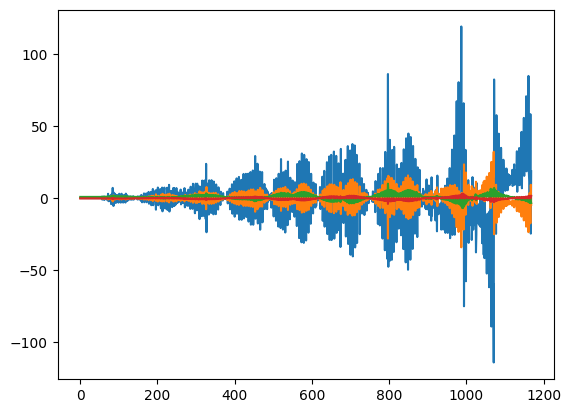

In [ ]:
Y_calc = model.predict(X)
plt.plot(Y, label='y')
plt.plot(Y_calc, label='y_calc')
plt.show()